Msc Data Science and Economics

Università degli Studi di Milano

Martina Viggiano (954603)

## *Perspectives on data sharing: a social media analysis*

# **3. Analysis of Filtered Data Notebook**

Summary:

1.   IMPORTS
2.   EXPLORATORY ANALYSIS
    * 2.1 Time Series per Year
    * 2.2 Define separate dfs for hastags and terms
    * 2.3 Extract month of publication
        * 2.3.1 Month of publication - Pre-Post covid era
    * 2.4 Number of terms per tweet
    * 2.5 Composition of tweets
3. MOST FREQUENT TERMS
    * 3.1 Top Frequent Single Terms
        * 3.1.1 Top Frequent Single Term - Pre-Post Covid19 era
    * 3.2 Top Frequent Bi-grams
        * 3.2.1 Top Frequent Bi-grams - Pre-Post Covid19 era
    * 3.3 Top Frequent Tri-grams
        * 3.3.1 Top Frequent Tri-grams - Pre-Post Covid19 era
    * 3.4 Top Frequent terms by POS
    * 3.5 Tf-Idf
4. HASHTAGS
5. SENTIMENT ANALYSIS
    * 5.1 Sentiment Analysis - Pre-Post Covid19 era
6. TOPIC MODELING
    * 6.1 Topic Modeling - Pre-Post Covid19 era
7. PERSPECTIVES THROUGH MODAL VERBS
    * 7.1 Perspectives Through Modal Verbs - Pre-Post Covid19 era

---

## 1. **IMPORTS**


We connect the notebook to our personal Google Drive folder: it will be used to store and load data.

In [ ]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Università/Thesis/')

We import and download libraries and packages.

In [ ]:
# install unidecode
!pip install -U spacy unidecode

In [ ]:
# install spacy and download english language
!python -m spacy download en_core_web_sm

In [ ]:
# install plotly
!pip install plotly==5.5.0

In [ ]:
# install gensim
!pip install gensim==3.8

In [ ]:
!pip install pyLDAvis

In [ ]:
!wget https://raw.githubusercontent.com/MaartenGr/cTFIDF/master/ctfidf.py # import c-TF-IDF package by MaartenGr. See: https://github.com/MaartenGr/cTFIDF

In [ ]:
# Import libraries
import pickle
import pandas as pd
import numpy as np
from functools import reduce
import datetime
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from ctfidf import CTFIDFVectorizer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
from google.colab import files

Load back data

In [ ]:
with open("/content/drive/MyDrive/Università/Thesis/keyword_df.pkl", "rb") as f:
    keyword_df = pickle.load(f)

In [ ]:
keyword_df.shape[0]

11959

Pre and post Covid19 era data

In [ ]:
with open("/content/drive/MyDrive/Università/Thesis/filter_pre_covid.pkl", "rb") as f:
    filter_pre_covid = pickle.load(f)
with open("/content/drive/MyDrive/Università/Thesis/filter_post_covid.pkl", "rb") as f:
    filter_post_covid = pickle.load(f)

Number of tweets per year

In [ ]:
with open("/content/drive/MyDrive/Università/Thesis/df_count_per_year_filter.pkl", "rb") as f:
    df_count_per_year_filter = pickle.load(f)

Conversations

In [ ]:
with open("/content/drive/MyDrive/Università/Thesis/data_merge_conversations_filter.pkl", "rb") as f:
    data_merge_conversations_filter = pickle.load(f)

---

## 2. **EXPLORATORY ANALYSIS**


The tweets we use in this notebook belong to dataset filtered by using the reasearch and academic terminology: *research, university, academy, publish, professor, availability, PhD, discovery, reproducibility, scientific community*.

### 2.1 Number of tweeets per Year 


We visualize the number of filtered tweets collected per each year from 2008 to 2021.

In [ ]:
df_count_per_year_filter

,year,count
0,2008,13
1,2009,62
2,2010,138
3,2011,172
4,2012,271
5,2013,738
6,2014,1087
7,2015,1151
8,2016,1383
9,2017,1174


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_count_per_year_filter['year'], y=df_count_per_year_filter['count'], text=df_count_per_year_filter['count'],
                    line = dict(color='royalblue')))

fig.update_layout(title='Number of tweets filtered extracted by keywords from 2008 to 2021 - Filtered data',
                   xaxis=dict(title='Years', tickmode='linear'),
                   yaxis_title='Number of tweets')

fig.show()

### 2.2 Define separate dfs for hastags and terms
We split data based on the presence of given keywords and hashtags. In particular, we create:

*   df_h_opendata : having #opendata
*   df_opendata : having "opendata" or "open data"
*   df_h_datasharing: having #datasharing
*   df_datasharing: having "datasharing" or "data sharing"
*   df_h_openscience: having #openscience
*   df_openscience: having "openscience" or "open science"
*   df_h_openresearch: having #openresearch
*   df_openresearch: having "openresearch" or "open research"



In [ ]:
df_h_opendata_filter = keyword_df[keyword_df['text'].str.contains('#opendata', case=False)]

In [ ]:
str_opendata = [' opendata', 'open data']
df_opendata_filter = keyword_df[keyword_df['text'].str.contains('|'.join(str_opendata), case=False)]

In [ ]:
df_h_datasharing_filter = keyword_df[keyword_df['text'].str.contains('#datasharing', case=False)]

In [ ]:
str_datasharing = [' datasharing', 'data sharing']
df_datasharing_filter = keyword_df[keyword_df['text'].str.contains('|'.join(str_datasharing), case=False)]

In [ ]:
df_h_openscience_filter = keyword_df[keyword_df['text'].str.contains('#openscience', case=False)]

In [ ]:
str_openscience = [' openscience', 'open science']
df_openscience_filter = keyword_df[keyword_df['text'].str.contains('|'.join(str_openscience), case=False)]

In [ ]:
df_h_openresearch_filter = keyword_df[keyword_df['text'].str.contains('#openresearch', case=False)]

In [ ]:
str_openresearch = [' openresearch', 'open research']
df_openresearch_filter = keyword_df[keyword_df['text'].str.contains('|'.join(str_openresearch), case=False)]

In [ ]:
def extract_year(df):
    df_year = df.year.value_counts().reset_index()
    df_year.columns = ['year', 'count']
    df_year['rel_frequency'] = ((df_year['count'] /  df_year['count'].sum()) * 100).round(2)
    df_year = df_year.sort_values('year').reset_index(drop=True)
    return df_year

In [ ]:
df_year_h_opendata_filter = extract_year(df_h_opendata_filter)
df_year_opendata_filter = extract_year(df_opendata_filter)
df_year_h_openscience_filter = extract_year(df_h_openscience_filter)
df_year_openscience_filter = extract_year(df_openscience_filter)
df_year_h_datasharing_filter = extract_year(df_h_datasharing_filter)
df_year_datasharing_filter = extract_year(df_datasharing_filter)
df_year_h_openresearch_filter = extract_year(df_h_openresearch_filter)
df_year_openresearch_filter = extract_year(df_openresearch_filter)

In [ ]:
fig = go.Figure()

fig = make_subplots(rows=2, cols=1, subplot_titles=("Absolute Frequency", "Relative Frequency"), vertical_spacing=0.15) #, row_heights=[2,2]

fig.add_trace(go.Scatter(x=df_year_h_opendata_filter['year'], y=df_year_h_opendata_filter['count'],
                   name='#opendata', line = dict(color='royalblue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_h_openscience_filter['year'], y=df_year_h_openscience_filter['count'],
                   name='#openscience', line = dict(color='firebrick')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_h_datasharing_filter['year'], y=df_year_h_datasharing_filter['count'],
                   name='#openresearch', line = dict(color='gold')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_h_openresearch_filter['year'], y=df_year_h_openresearch_filter['count'],
                   name='#datasharing', line = dict(color='forestgreen')), row=1, col=1)

fig.add_trace(go.Scatter(x=df_year_opendata_filter['year'], y=df_year_opendata_filter['count'],
                   name='opendata', line = dict(color='royalblue', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_openscience_filter['year'], y=df_year_openscience_filter['count'],
                   name='openscience', line = dict(color='firebrick', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_datasharing_filter['year'], y=df_year_datasharing_filter['count'],
                   name='openresearch', line = dict(color='gold', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_year_openresearch_filter['year'], y=df_year_openresearch_filter['count'],
                   name='datasharing', line = dict(color='forestgreen', dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=df_year_h_opendata_filter['year'], y=df_year_h_opendata_filter['rel_frequency'],
                   name='#opendata', line = dict(color='royalblue'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_h_openscience_filter['year'], y=df_year_h_openscience_filter['rel_frequency'],
                   name='#openscience', line = dict(color='firebrick'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_h_datasharing_filter['year'], y=df_year_h_datasharing_filter['rel_frequency'],
                   name='#openresearch', line = dict(color='gold'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_h_openresearch_filter['year'], y=df_year_h_openresearch_filter['rel_frequency'],
                   name='#datasharing', line = dict(color='forestgreen'), legendgroup='group1', showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=df_year_opendata_filter['year'], y=df_year_opendata_filter['rel_frequency'],
                   name='opendata', line = dict(color='royalblue', dash='dash'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_openscience_filter['year'], y=df_year_openscience_filter['rel_frequency'],
                   name='openscience', line = dict(color='firebrick', dash='dash'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_datasharing_filter['year'], y=df_year_datasharing_filter['rel_frequency'],
                   name='openresearch', line = dict(color='gold', dash='dash'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df_year_openresearch_filter['year'], y=df_year_openresearch_filter['rel_frequency'],
                   name='datasharing', line = dict(color='forestgreen', dash='dash'), legendgroup='group1', showlegend=False), row=2, col=1)

fig.update_xaxes(title_text="Years", row=1, col=1)
fig.update_xaxes(title_text="Years", row=2, col=1)

fig.update_yaxes(title_text="N", row=1, col=1)
fig.update_yaxes(title_text="%", row=2, col=1)

fig.update_layout(title_text="Frequency of tweets within years per keyword and hashtag - Filtered data", height=800, width=1400)

fig.show()

### 2.3 Extract month of publication

In [ ]:
keyword_df['month'] = keyword_df['date'].dt.month

In [ ]:
def extract_month(df):
    df['month'] = df['date'].dt.month
    df_month = df.month.value_counts().reset_index()
    df_month.columns = ['month', 'count']
    df_month['rel_frequency'] = ((df_month['count'] /  df_month['count'].sum()) * 100).round(2)
    df_month = df_month.sort_values('month').reset_index(drop=True)
    df_month['month'] = df_month['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    return df_month

In [ ]:
df_month_h_opendata_filter = extract_month(df_h_opendata_filter)
df_month_opendata_filter = extract_month(df_opendata_filter)
df_month_h_openscience_filter = extract_month(df_h_openscience_filter)
df_month_openscience_filter = extract_month(df_openscience_filter)
df_month_h_datasharing_filter = extract_month(df_h_datasharing_filter)
df_month_datasharing_filter = extract_month(df_datasharing_filter)
df_month_h_openresearch_filter = extract_month(df_h_openresearch_filter)
df_month_openresearch_filter = extract_month(df_openresearch_filter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_month_opendata_filter

,month,count,rel_frequency
0,Jan,169,6.82
1,Feb,210,8.48
2,Mar,216,8.72
3,Apr,208,8.40
4,May,222,8.96
5,June,215,8.68
6,July,196,7.91
7,Aug,146,5.89
8,Sep,230,9.29
9,Oct,279,11.26


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_month_h_opendata_filter['month'], y=df_month_h_opendata_filter['rel_frequency'],
                   name='#opendata', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df_month_h_openscience_filter['month'], y=df_month_h_openscience_filter['rel_frequency'],
                   name='#openscience', line = dict(color='firebrick')))
fig.add_trace(go.Scatter(x=df_month_h_openresearch_filter['month'], y=df_month_h_openresearch_filter['rel_frequency'],
                   name='#openresearch', line = dict(color='gold')))
fig.add_trace(go.Scatter(x=df_month_h_datasharing_filter['month'], y=df_month_h_datasharing_filter['rel_frequency'],
                   name='#datasharing', line = dict(color='forestgreen')))

fig.add_trace(go.Scatter(x=df_month_opendata_filter['month'], y=df_month_opendata_filter['rel_frequency'],
                   name='opendata', line = dict(color='royalblue', dash='dash')))
fig.add_trace(go.Scatter(x=df_month_openscience_filter['month'], y=df_month_openscience_filter['rel_frequency'],
                   name='openscience', line = dict(color='firebrick', dash='dash')))
fig.add_trace(go.Scatter(x=df_month_openresearch_filter['month'], y=df_month_openresearch_filter['rel_frequency'],
                   name='openresearch', line = dict(color='gold', dash='dash')))
fig.add_trace(go.Scatter(x=df_month_datasharing_filter['month'], y=df_month_datasharing_filter['rel_frequency'],
                   name='datasharing', line = dict(color='forestgreen', dash='dash')))

fig.update_layout(title='Frequency of tweets within months per keyword and hashtag - Filtered data',
                   xaxis=dict(title='Months', tickmode='linear'),
                   yaxis_title='%')

fig.show()

### 2.3.1 Month of publication - Pre-Post covid era

In [ ]:
df_month_pre_filter = extract_month(filter_pre_covid)
df_month_post_filter = extract_month(filter_post_covid)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_month_pre_filter['month'], y=df_month_pre_filter['rel_frequency'],
                   name='Pre-Covid19', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df_month_post_filter['month'], y=df_month_post_filter['rel_frequency'],
                   name='Post-Covid19', line = dict(color='firebrick')))

fig.update_layout(title='Frequency of tweets within months between Pre and Post Covid19 era - Filtered data',
                   xaxis=dict(title='Months', tickmode='linear'),
                   yaxis_title='%')

fig.show()

### 2.4 Number of terms per tweet

In [ ]:
n_terms_raw_filter = keyword_df['text'].apply(lambda x: len(x.split()))
n_terms_clean_filter = keyword_df['text_clean'].apply(lambda x: len(x.split()))

fig = go.Figure()
fig.add_trace(go.Histogram(x=n_terms_raw_filter, name='Raw tweets'))
fig.add_trace(go.Histogram(x=n_terms_clean_filter, name='Cleaned tweets'))

fig.update_layout(barmode='overlay') # Overlay both histograms

fig.update_traces(opacity=0.75) # Reduce opacity to see both histograms

fig.update_xaxes(range=[0, 60])

fig.update_layout(title='Number of tokens per tweet - Filtered data',
                   xaxis=dict(title='Number of Tokens'),
                   yaxis_title='Tweet Frequency')

fig.show()

In [ ]:
print('Average number of terms per tweet before cleaning :', n_terms_raw_filter.mean())
print('Average number of terms per tweet after cleaning :', n_terms_clean_filter.mean())

Average number of terms per tweet before cleaning : 26.756083284555565
Average number of terms per tweet after cleaning : 12.57337570030939


In [ ]:
print('Median number of terms per tweet before cleaning :', n_terms_raw_filter.median())
print('Median number of terms per tweet after cleaning :', n_terms_clean_filter.median())

Median number of terms per tweet before cleaning : 22.0
Median number of terms per tweet after cleaning : 11.0


### 2.5 Composition of tweets

We look for propotions between tweets with hashtags and tweets with keywords.

In [ ]:
both_opendata = len(keyword_df[(keyword_df['text_clean'].str.contains('opendata')) & (keyword_df['hashtags'].str.contains('opendata'))])

In [ ]:
single_opendata = len(keyword_df[(keyword_df['text_clean'].str.contains('opendata')) | (keyword_df['hashtags'].str.contains('opendata'))])

In [ ]:
(both_opendata/single_opendata)*100

1.4545454545454546

In [ ]:
both_openscience = len(keyword_df[(keyword_df['text_clean'].str.contains('openscience')) & (keyword_df['hashtags'].str.contains('openscience'))])

In [ ]:
single_openscience = len(keyword_df[(keyword_df['text_clean'].str.contains('openscience')) | (keyword_df['hashtags'].str.contains('openscience'))])

In [ ]:
(both_openscience/single_openscience)*100

2.0073956682514527

In [ ]:
both_openresearch = len(keyword_df[(keyword_df['text_clean'].str.contains('openresearch')) & (keyword_df['hashtags'].str.contains('openresearch'))])

In [ ]:
single_openresearch = len(keyword_df[(keyword_df['text_clean'].str.contains('openresearch')) | (keyword_df['hashtags'].str.contains('openresearch'))])

In [ ]:
(both_openresearch/single_openresearch)*100

1.4629049111807733

In [ ]:
both_datasharing = len(keyword_df[(keyword_df['text_clean'].str.contains('datasharing')) & (keyword_df['hashtags'].str.contains('datasharing'))])

In [ ]:
single_datasharing = len(keyword_df[(keyword_df['text_clean'].str.contains('datasharing')) | (keyword_df['hashtags'].str.contains('datasharing'))])

In [ ]:
(both_datasharing/single_datasharing)*100

0.9433962264150944

---

## 3. **MOST FREQUENT TERMS**

### 3.1 Top Frequent Single Terms

We plot the top most frequent terms of the entire dataset.

In [ ]:
def get_top_n_words_(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    unique = set(corpus.str.split(' ').sum())
    c = pd.DataFrame.from_dict({word: (freq/len(unique)).round(3) for word, freq in words_freq[:n]}, orient='index').reset_index()
    c = c.rename(columns={'index': 'words', 0: 'freq'})
    return c

In [ ]:
cmw = get_top_n_words_(keyword_df['text_clean'], 50)
cmw.columns = ["words", "freq"]
cmw_notop = get_top_n_words_(keyword_df['text_clean_notop'], 50)
cmw_notop.columns = ["words", "freq"]
cmw_21 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2021], 50)
cmw_21.columns = ["words", "freq"]
cmw_20 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2020], 50)
cmw_20.columns = ["words", "freq"]
cmw_19 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2019], 50)
cmw_19.columns = ["words", "freq"]
cmw_18 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2018], 50)
cmw_18.columns = ["words", "freq"]
cmw_17 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2017], 50)
cmw_17.columns = ["words", "freq"]
cmw_16 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2016], 50)
cmw_16.columns = ["words", "freq"]
cmw_15 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2015], 50)
cmw_15.columns = ["words", "freq"]
cmw_14 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2014], 50)
cmw_14.columns = ["words", "freq"]
cmw_13 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2013], 50)
cmw_13.columns = ["words", "freq"]
cmw_12 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2012], 50)
cmw_12.columns = ["words", "freq"]
cmw_11 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2011], 50)
cmw_11.columns = ["words", "freq"]
cmw_10 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2010], 50)
cmw_10.columns = ["words", "freq"]
cmw_09 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2009], 50)
cmw_09.columns = ["words", "freq"]
cmw_08 = get_top_n_words_(keyword_df['text_clean_notop'][keyword_df['date'].dt.year==2008], 50)
cmw_08.columns = ["words", "freq"]

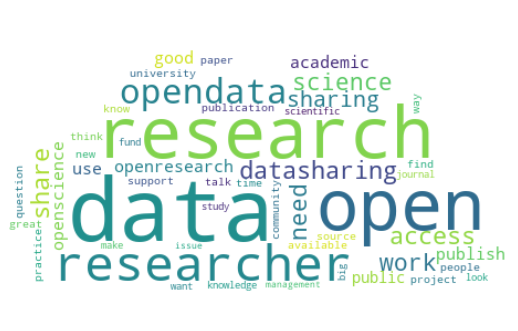

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Most Frequent Terms - Entire set

path_cloud = "/content/drive/MyDrive/Università/Thesis/images/cloud.png"
cloud = np.array(Image.open(path_cloud))

text = ' '.join(cmw['words'].values)

wordcloud = WordCloud(background_color="white", mask=cloud, width=800, height=400).generate(text)

fig = plt.figure(figsize=(7,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig('word_cloud.png')
files.download('word_cloud.png')

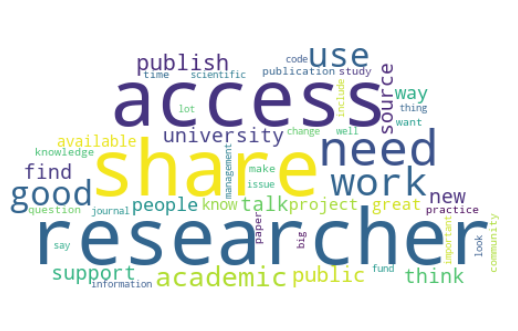

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Most Frequent Terms - Without top terms

text_notop = ' '.join(cmw_notop['words'].values)

wordcloud = WordCloud(background_color="white", mask=cloud, width=800, height=400).generate(text_notop)

fig = plt.figure(figsize=(7,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
fig.savefig('word_cloud.png')
files.download('word_cloud.png')

In [ ]:
first_10 = pd.concat([cmw[:10], cmw_notop[:10]], axis=1, names=["group_key"])
first_10.columns = ['words_tot', 'freq_tot', 'words_notop', 'freq_notop']
first_10

,words_tot,freq_tot,words_notop,freq_notop
0,data,0.621,researcher,0.146
1,research,0.584,access,0.112
2,open,0.402,share,0.107
3,researcher,0.146,need,0.080
4,opendata,0.131,work,0.068
5,datasharing,0.115,good,0.054
6,access,0.112,use,0.050
7,share,0.107,academic,0.049
8,science,0.085,like,0.047
9,need,0.080,publish,0.046


In [ ]:
top_terms_years = pd.concat([cmw_08[:10], cmw_09[:10], cmw_10[:10], cmw_11[:10], cmw_12[:10], cmw_13[:10], cmw_14[:10],
                             cmw_15[:10], cmw_16[:10], cmw_17[:10], cmw_18[:10], cmw_19[:10], cmw_20[:10], cmw_21[:10]],
                            axis=1)
top_terms_years.set_axis(['2008', ' ', '2009', ' ', '2010', ' ', '2011', ' ', '2012', ' ', '2013', ' ', '2014', ' ', '2015', ' ', '2016', ' ', '2017', ' ', '2018', ' ', '2019', ' ', '2020', ' ', '2021', ' '], axis=1)

,2008,,2009,,2010,,2011,,2012,,2013,,2014,,2015,,2016,,2017,,2018,,2019,,2020,,2021,
0,community,0.040,public,0.029,access,0.026,researcher,0.045,access,0.045,access,0.054,researcher,0.062,researcher,0.061,researcher,0.068,researcher,0.065,researcher,0.062,researcher,0.044,researcher,0.054,researcher,0.059
1,talk,0.027,researcher,0.020,share,0.026,share,0.032,need,0.032,researcher,0.043,access,0.050,access,0.053,share,0.047,access,0.043,access,0.051,access,0.040,share,0.051,share,0.044
2,publish,0.027,available,0.020,researcher,0.026,access,0.025,researcher,0.030,need,0.028,share,0.034,share,0.041,access,0.044,share,0.038,share,0.043,share,0.038,work,0.035,access,0.035
3,think,0.027,share,0.020,university,0.023,publication,0.022,share,0.029,share,0.025,need,0.028,need,0.037,need,0.033,need,0.030,need,0.034,work,0.034,access,0.032,work,0.034
4,online,0.027,publish,0.017,good,0.019,need,0.022,public,0.025,academic,0.025,talk,0.020,academic,0.023,good,0.022,work,0.022,work,0.030,need,0.029,need,0.029,need,0.028
5,available,0.027,way,0.011,available,0.018,fund,0.021,fund,0.023,publish,0.023,publish,0.019,work,0.021,academic,0.020,talk,0.021,good,0.026,like,0.026,find,0.024,like,0.024
6,user,0.027,need,0.011,publish,0.018,academic,0.019,publication,0.019,talk,0.019,work,0.019,university,0.021,use,0.019,good,0.020,use,0.023,good,0.026,like,0.023,university,0.021
7,give,0.027,access,0.011,project,0.018,university,0.016,publish,0.018,good,0.018,public,0.019,good,0.020,university,0.019,new,0.019,like,0.023,use,0.024,time,0.019,people,0.020
8,network,0.027,online,0.011,need,0.018,good,0.015,scientific,0.017,publication,0.016,academic,0.018,use,0.020,publish,0.018,great,0.016,think,0.022,people,0.022,paper,0.019,academic,0.020
9,need,0.013,good,0.011,report,0.016,work,0.015,academic,0.017,new,0.016,good,0.016,new,0.017,talk,0.017,source,0.016,way,0.020,think,0.021,think,0.019,knowledge,0.020


|index|2008| |2009| |2010| |2011| |2012| |2013| |2014| |2015| |2016| |2017| 2018| |2019| |2020| |2021| | |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|community|0\.039|public|0\.028|access|0\.026|researcher|0\.045|access|0\.046|access|0\.054|researcher|0\.062|researcher|0\.061|researcher|0\.068|researcher|0\.065|researcher|0\.062|researcher|0\.044|researcher|0\.054|researcher|0\.059|
|1|talk|0\.026|researcher|0\.02|share|0\.026|share|0\.032|need|0\.032|researcher|0\.042|access|0\.05|access|0\.053|share|0\.047|access|0\.043|access|0\.052|access|0\.04|share|0\.051|share|0\.044|
|2|publish|0\.026|available|0\.02|researcher|0\.026|datashare|0\.027|researcher|0\.03|need|0\.028|share|0\.034|share|0\.041|access|0\.044|share|0\.038|share|0\.044|share|0\.038|work|0\.035|access|0\.035|
|3|think|0\.026|share|0\.02|university|0\.023|access|0\.025|datashare|0\.03|share|0\.026|need|0\.028|need|0\.037|need|0\.033|need|0\.03|need|0\.035|work|0\.035|access|0\.032|work|0\.033|
|4|online|0\.026|publish|0\.017|good|0\.019|publication|0\.022|share|0\.029|academic|0\.025|datashare|0\.021|academic|0\.022|datashare|0\.031|datashare|0\.022|work|0\.03|need|0\.029|need|0\.029|need|0\.027|
|5|available|0\.026|way|0\.011|available|0\.018|need|0\.022|public|0\.027|publish|0\.023|talk|0\.021|work|0\.021|good|0\.022|work|0\.022|good|0\.026|like|0\.026|find|0\.024|like|0\.024|
|6|user|0\.026|need|0\.011|publish|0\.018|fund|0\.021|fund|0\.023|datashare|0\.019|publish|0\.019|university|0\.021|academic|0\.02|talk|0\.022|use|0\.023|good|0\.026|like|0\.023|university|0\.021|
|7|give|0\.026|access|0\.011|project|0\.018|academic|0\.019|publish|0\.019|talk|0\.019|work|0\.019|datashare|0\.021|use|0\.02|good|0\.02|like|0\.023|use|0\.024|time|0\.02|people|0\.02|
|8|network|0\.026|online|0\.011|need|0\.018|university|0\.016|publication|0\.019|good|0\.018|public|0\.019|good|0\.02|university|0\.019|new|0\.019|think|0\.022|people|0\.022|paper|0\.019|academic|0\.02|
|9|datashare|0\.026|good|0\.011|report|0\.016|good|0\.015|scientific|0\.017|publication|0\.016|academic|0\.018|use|0\.02|publish|0\.018|use|0\.016|way|0\.02|think|0\.021|think|0\.019|knowledge|0\.02|

We look for terms present in each* top 50 most frequent terms per year.


Please note: we did not consider 2008 computing the intersection between top 50 most frequent terms because of its numerousness with respect to the other years. 

In [ ]:
intersection = reduce(np.intersect1d, [cmw_09['words'], cmw_10['words'], cmw_11['words'], cmw_12['words'], cmw_13['words'], cmw_14['words'], 
                                       cmw_15['words'], cmw_16['words'], cmw_17['words'], cmw_18['words'], cmw_19['words'], cmw_20['words'], cmw_21['words']])

We visualize the intersection betweetn top 50 most frequent words sets of each year.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_08['words'][cmw_08['words'].isin(intersection)],
    y=cmw_08['freq'][cmw_08['words'].isin(intersection)],
    name='2008',
    marker_color='steelblue',
))
fig.add_trace(go.Bar(
    x=cmw_09['words'][cmw_09['words'].isin(intersection)],
    y=cmw_09['freq'][cmw_09['words'].isin(intersection)],
    name='2009',
    marker_color='tan'
))
fig.add_trace(go.Bar(
    x=cmw_10['words'][cmw_10['words'].isin(intersection)],
    y=cmw_10['freq'][cmw_10['words'].isin(intersection)],
    name='2010',
    marker_color='grey'
))
fig.add_trace(go.Bar(
    x=cmw_11['words'][cmw_11['words'].isin(intersection)],
    y=cmw_11['freq'][cmw_11['words'].isin(intersection)],
    name='2011',
    marker_color='orchid'
))
fig.add_trace(go.Bar(
    x=cmw_12['words'][cmw_12['words'].isin(intersection)],
    y=cmw_12['freq'][cmw_12['words'].isin(intersection)],
    name='2012',
    marker_color='lightseagreen'
))
fig.add_trace(go.Bar(
    x=cmw_13['words'][cmw_13['words'].isin(intersection)],
    y=cmw_13['freq'][cmw_13['words'].isin(intersection)],
    name='2013',
    marker_color='tomato'
))
fig.add_trace(go.Bar(
    x=cmw_14['words'][cmw_14['words'].isin(intersection)],
    y=cmw_14['freq'][cmw_14['words'].isin(intersection)],
    name='2014',
    marker_color='slateblue'
))
fig.add_trace(go.Bar(
    x=cmw_15['words'][cmw_15['words'].isin(intersection)],
    y=cmw_15['freq'][cmw_15['words'].isin(intersection)],
    name='2015',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=cmw_16['words'][cmw_16['words'].isin(intersection)],
    y=cmw_16['freq'][cmw_16['words'].isin(intersection)],
    name='2016',
    marker_color='mediumorchid'
))
fig.add_trace(go.Bar(
    x=cmw_17['words'][cmw_17['words'].isin(intersection)],
    y=cmw_17['freq'][cmw_17['words'].isin(intersection)],
    name='2017',
    marker_color='yellowgreen'
))
fig.add_trace(go.Bar(
    x=cmw_18['words'][cmw_18['words'].isin(intersection)],
    y=cmw_18['freq'][cmw_18['words'].isin(intersection)],
    name='2018',
    marker_color='gold'
))
fig.add_trace(go.Bar(
    x=cmw_19['words'][cmw_19['words'].isin(intersection)],
    y=cmw_19['freq'][cmw_19['words'].isin(intersection)],
    name='2019',
    marker_color='cornflowerblue'
))
fig.add_trace(go.Bar(
    x=cmw_20['words'][cmw_20['words'].isin(intersection)],
    y=cmw_20['freq'][cmw_20['words'].isin(intersection)],
    name='2020',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=cmw_21['words'][cmw_21['words'].isin(intersection)],
    y=cmw_21['freq'][cmw_21['words'].isin(intersection)],
    name='2021',
    marker_color='indianred'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Common Terms within top 50 terms of each year - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

We also plot the words belonging to top 5 of each year, but which are not shared by all top 50 most frequent terms of the years (i.e. not present in the intersection we computed).

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_08['words'][~cmw_08['words'].isin(intersection)][:5],
    y=cmw_08['freq'][~cmw_08['words'].isin(intersection)][:5],
    name='2008',
    marker_color='steelblue'
))
fig.add_trace(go.Bar(
    x=cmw_09['words'][~cmw_09['words'].isin(intersection)][:5],
    y=cmw_09['freq'][~cmw_09['words'].isin(intersection)][:5],
    name='2009',
    marker_color='tan'
))
fig.add_trace(go.Bar(
    x=cmw_10['words'][~cmw_10['words'].isin(intersection)][:5],
    y=cmw_10['freq'][~cmw_10['words'].isin(intersection)][:5],
    name='2010',
    marker_color='grey'
))
fig.add_trace(go.Bar(
    x=cmw_11['words'][~cmw_11['words'].isin(intersection)][:5],
    y=cmw_11['freq'][~cmw_11['words'].isin(intersection)][:5],
    name='2011',
    marker_color='orchid'
))
fig.add_trace(go.Bar(
    x=cmw_12['words'][~cmw_12['words'].isin(intersection)][:5],
    y=cmw_12['freq'][~cmw_12['words'].isin(intersection)][:5],
    name='2012',
    marker_color='lightseagreen'
))
fig.add_trace(go.Bar(
    x=cmw_13['words'][~cmw_13['words'].isin(intersection)][:5],
    y=cmw_13['freq'][~cmw_13['words'].isin(intersection)][:5],
    name='2013',
    marker_color='tomato'
))
fig.add_trace(go.Bar(
    x=cmw_14['words'][~cmw_14['words'].isin(intersection)][:5],
    y=cmw_14['freq'][~cmw_14['words'].isin(intersection)][:5],
    name='2014',
    marker_color='slateblue'
))
fig.add_trace(go.Bar(
    x=cmw_15['words'][~cmw_15['words'].isin(intersection)][:5],
    y=cmw_15['freq'][~cmw_15['words'].isin(intersection)][:5],
    name='2015',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=cmw_16['words'][~cmw_16['words'].isin(intersection)][:5],
    y=cmw_16['freq'][~cmw_16['words'].isin(intersection)][:5],
    name='2016',
    marker_color='mediumorchid'
))
fig.add_trace(go.Bar(
    x=cmw_17['words'][~cmw_17['words'].isin(intersection)][:5],
    y=cmw_17['freq'][~cmw_17['words'].isin(intersection)][:5],
    name='2017',
    marker_color='yellowgreen'
))
fig.add_trace(go.Bar(
    x=cmw_18['words'][~cmw_18['words'].isin(intersection)][:5],
    y=cmw_18['freq'][~cmw_18['words'].isin(intersection)][:5],
    name='2018',
    marker_color='gold'
))
fig.add_trace(go.Bar(
    x=cmw_19['words'][~cmw_19['words'].isin(intersection)][:5],
    y=cmw_19['freq'][~cmw_19['words'].isin(intersection)][:5],
    name='2019',
    marker_color='cornflowerblue'
))
fig.add_trace(go.Bar(
    x=cmw_20['words'][~cmw_20['words'].isin(intersection)][:5],
    y=cmw_20['freq'][~cmw_20['words'].isin(intersection)][:5],
    name='2020',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=cmw_21['words'][~cmw_21['words'].isin(intersection)][:5],
    y=cmw_21['freq'][~cmw_21['words'].isin(intersection)][:5],
    name='2021',
    marker_color='indianred'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Uncommon terms within top 5 terms of each year - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

#### 3.3.1 Top Frequent Single Terms - Pre-Post Covid19 era

In [ ]:
cmw_pre = get_top_n_words_(filter_pre_covid['text_clean_notop'], 50)
cmw_pre.columns = ["words", "freq"]
cmw_post = get_top_n_words_(filter_post_covid['text_clean_notop'], 50)
cmw_post.columns = ["words", "freq"]

In [ ]:
intersection_pre_post= reduce(np.intersect1d, [cmw_pre['words'], cmw_post['words']])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_pre['words'][cmw_pre['words'].isin(intersection_pre_post)],
    y=cmw_pre['freq'][cmw_pre['words'].isin(intersection_pre_post)],
    name='Pre-Covid19 era',
    marker_color='steelblue'
))
fig.add_trace(go.Bar(
    x=cmw_post['words'][cmw_post['words'].isin(intersection_pre_post)],
    y=cmw_post['freq'][cmw_post['words'].isin(intersection_pre_post)],
    name='Post-Covid19 era',
    marker_color='tan'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Comparison Frequent terms within top 50 terms between Pre-Post Covid19 era - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_pre['words'][~cmw_pre['words'].isin(cmw_post['words'])],
    y=cmw_pre['freq'][~cmw_pre['words'].isin(cmw_post['words'])],
    name='Pre-Covid19 era',
    marker_color='steelblue',
     width=0.3
))
fig.add_trace(go.Bar(
    x=cmw_post['words'][~cmw_post['words'].isin(cmw_pre['words'])],
    y=cmw_post['freq'][~cmw_post['words'].isin(cmw_pre['words'])],
    name='Post-Covid19 era',
    marker_color='tan',
     width=0.3
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Comparison Uncommon terms between Pre-Post Covid19 era - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

In [ ]:
pre_notpost_single = cmw_pre['words'][~cmw_pre['words'].isin(cmw_post['words'])]
pre_notpost_single

35      analysis
36           big
37         issue
38          come
40    management
41           say
46        change
47       provide
Name: words, dtype: object

In [ ]:
post_notpre_single = cmw_post['words'][~cmw_post['words'].isin(cmw_pre['words'])]
post_notpre_single

10    knowledge
30      dataset
35         code
39      student
41     resource
47         year
48        covid
49      article
Name: words, dtype: object

### 3.2 Top Frequent Bi-grams

In [ ]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [ ]:
bigrams=defaultdict(int)
for text in keyword_df.text_clean_notop:
  for word in generate_N_grams(text,2):
    bigrams[word]+=1

In [ ]:
top_bigrams = {k: v for k, v in sorted(bigrams.items(), key=lambda item: item[1], reverse=True)[:20]}

In [ ]:
top_bigrams_sorted = sorted(top_bigrams.items(), key=lambda x: x[1], reverse=True)  

In [ ]:
top_bigrams_df = pd.DataFrame.from_dict(top_bigrams_sorted)
top_bigrams_df.set_axis(['bigram', 'count'], axis=1, inplace=True)
top_bigrams_df[:10]

,bigram,count
0,publicly fund,79
1,good practice,65
2,access publication,51
3,researcher share,50
4,researcher need,48
5,access publishing,45
6,publicly available,44
7,social media,44
8,early career,42
9,clinical trial,42


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_bigrams_df['bigram'],
    y=top_bigrams_df['count'],
    marker_color='steelblue',
    width=0.3
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Bi-grams - Filtered data',
                   yaxis_title='Bi-grams Frequency')
fig.show()

### 3.2.1 Top Frequent Bi-grams - Pre-Post Covid19 era

In [ ]:
bigrams_pre=defaultdict(int)
for text in filter_pre_covid.text_clean_notop:
  for word in generate_N_grams(text,2):
    bigrams_pre[word]+=1
top_bigrams_pre = {k: v for k, v in sorted(bigrams_pre.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bigrams_sorted_pre = sorted(top_bigrams_pre.items(), key=lambda x: x[1], reverse=True)  

In [ ]:
top_bigrams_df_pre = pd.DataFrame.from_dict(top_bigrams_sorted_pre)
top_bigrams_df_pre.set_axis(['bigram', 'count'], axis=1, inplace=True)

In [ ]:
bigrams_post=defaultdict(int)
for text in filter_post_covid.text_clean_notop:
  for word in generate_N_grams(text,2):
    bigrams_post[word]+=1
top_bigrams_post = {k: v for k, v in sorted(bigrams_post.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bigrams_sorted_post = sorted(top_bigrams_post.items(), key=lambda x: x[1], reverse=True)  

In [ ]:
top_bigrams_df_post = pd.DataFrame.from_dict(top_bigrams_sorted_post)
top_bigrams_df_post.set_axis(['bigram', 'count'], axis=1, inplace=True)

In [ ]:
pre_notpost_bi = top_bigrams_df_pre['bigram'][~top_bigrams_df_pre['bigram'].isin(top_bigrams_df_post['bigram'])]
pre_notpost_bi

1               publicly fund
2          publicly available
4          access publication
8              clinical trial
9           access management
10                  look like
11                 make sense
12                   find way
14                 share code
15           allow researcher
16            management plan
17           pre registration
18    scholarly communication
19            answer question
Name: bigram, dtype: object

In [ ]:
post_notpre_bi = top_bigrams_df_post['bigram'][~top_bigrams_df_post['bigram'].isin(top_bigrams_df_pre['bigram'])]
post_notpre_bi

1            covid dataset
2               case study
3     educational resource
6                long term
7       researcher publish
8               thing like
10         researcher work
11        freely available
12        researcher share
13            dataset cord
14         researcher need
15         share knowledge
18                year ago
19           impact factor
Name: bigram, dtype: object

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_bigrams_df_pre['bigram'],
    y=top_bigrams_df_pre['count'],
    name = 'Pre-Covid19 era',
    marker_color='steelblue',
    width=0.3
))
fig.add_trace(go.Bar(
    x=top_bigrams_df_post['bigram'],
    y=top_bigrams_df_post['count'],
     name = 'Post-Covid19 era',
    marker_color='tan',
    width=0.3
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Comparison Frequent Bigrams between Pre-Post Covid19 era - Filtered data',
                   yaxis_title='Bigrams Frequency')
fig.show()

### 3.3 Top Frequent Tri-grams

In [ ]:
trigrams=defaultdict(int)
for text in keyword_df.text_clean_notop:
  for word in generate_N_grams(text,3):
    trigrams[word]+=1

In [ ]:
top_trigrams = {k: v for k, v in sorted(trigrams.items(), key=lambda item: item[1], reverse=True)[:20]}
top_trigrams_sorted = sorted(top_trigrams.items(), key=lambda x: x[1], reverse=True) 

In [ ]:
top_trigrams_df = pd.DataFrame.from_dict(top_trigrams_sorted)
top_trigrams_df.set_axis(['trigram', 'count'], axis=1, inplace=True)
top_trigrams_df[:10]

,trigram,count
0,early career researcher,32
1,possible close necessary,13
2,educational resource oer,9
3,covid dataset cord,8
4,human genome project,7
5,robert jan smit,7
6,access publicly fund,6
7,access scientific publication,6
8,high impact journal,6
9,researcher want share,6


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_trigrams_df['trigram'],
    y=top_trigrams_df['count'],
    marker_color='steelblue',
    width=0.3,
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Trigrams - Filtered data',
                   yaxis_title='Trigrams Frequency')
fig.show()

### 3.3.1 Top common Tri-grams - Pre-Post Covid19 era

In [ ]:
trigrams_pre=defaultdict(int)
for text in filter_pre_covid.text_clean_notop:
  for word in generate_N_grams(text,3):
    trigrams_pre[word]+=1
top_trigrams_pre = {k: v for k, v in sorted(trigrams_pre.items(), key=lambda item: item[1], reverse=True)[:20]}
top_trigrams_sorted_pre = sorted(top_trigrams_pre.items(), key=lambda x: x[1], reverse=True)  

In [ ]:
top_trigrams_df_pre = pd.DataFrame.from_dict(top_trigrams_sorted_pre)
top_trigrams_df_pre.set_axis(['trigram', 'count'], axis=1, inplace=True)

In [ ]:
trigrams_post=defaultdict(int)
for text in filter_post_covid.text_clean_notop:
  for word in generate_N_grams(text,3):
    trigrams_post[word]+=1
top_trigrams_post = {k: v for k, v in sorted(trigrams_post.items(), key=lambda item: item[1], reverse=True)[:20]}
top_trigrams_sorted_post = sorted(top_trigrams_post.items(), key=lambda x: x[1], reverse=True)  

In [ ]:
top_trigrams_df_post = pd.DataFrame.from_dict(top_trigrams_sorted_post)
top_trigrams_df_post.set_axis(['trigram', 'count'], axis=1, inplace=True)

In [ ]:
pre_notpost_tri = top_trigrams_df_pre['trigram'][~top_trigrams_df_pre['trigram'].isin(top_trigrams_df_post['trigram'])]
pre_notpost_tri

1                       robert jan smit
2                         need find way
3        scholarly communication access
4              possible close necessary
6                 publish royal society
7          management access publishing
8        publicly accessible repository
9     findable accessible interoperable
10    accessible interoperable reusable
11                    come ask question
12                    risk cost surplus
13         exploit commercial copyright
14           commercial copyright value
15           requirement education meet
16             education meet challenge
17           meet challenge opportunity
18          challenge opportunity learn
19              opportunity learn salon
Name: trigram, dtype: object

In [ ]:
post_notpre_tri = top_trigrams_df_post['trigram'][~top_trigrams_df_post['trigram'].isin(top_trigrams_df_pre['trigram'])]
post_notpre_tri

1                      covid dataset cord
3                      half paper publish
4               researcher degree freedom
5                   social media platform
6                           new way share
7               article processing charge
8     recommendation educational resource
9                microsoft academic graph
10                   professor sir duncan
11                     sir duncan wingham
12      ethical practical epistemological
13                 long term preservation
14                    art humanity social
15                       great half paper
16                   paper publish member
17                   university hong kong
18                 love hate relationship
19           specification curve analysis
Name: trigram, dtype: object

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_trigrams_df_pre['trigram'],
    y=top_trigrams_df_pre['count'],
    name = 'Pre-Covid19 era',
    marker_color='steelblue',
    width=0.3
))
fig.add_trace(go.Bar(
    x=top_trigrams_df_post['trigram'],
    y=top_trigrams_df_post['count'],
     name = 'Post-Covid19 era',
    marker_color='tan',
    width=0.3
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Comparison Frequent Trigrams between Pre-Post Covid19 era - Filtered data',
                   yaxis_title='Trigrams Frequency')
fig.show()

### 3.4 Top common terms by POS

We separate terms by Part of Speech (POS).

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
pipe = nlp.pipe(keyword_df['text_clean_notop'], n_process=2, batch_size=2000)

In [ ]:
docs = [x for x in tqdm(pipe)]

0it [00:00, ?it/s]

In [ ]:
keyword_df['spacy_doc'] = docs

In [ ]:
keyword_df['POS_spacy'] = keyword_df['spacy_doc'].apply(lambda x: [(y.text, y.pos_) for y in x])

In [ ]:
def get_sub(x):
    for tok in x:
        if (tok.dep_ == "nsubj"):
            return tok

In [ ]:
keyword_df['subject'] = keyword_df['spacy_doc'].apply(lambda x: get_sub(x))

In [ ]:
pipe_pre = nlp.pipe(filter_pre_covid['text'], n_process=2, batch_size=2000)

In [ ]:
docs_pre = [x for x in tqdm(pipe_pre)]

0it [00:00, ?it/s]

In [ ]:
filter_pre_covid['spacy_doc'] = docs_pre

In [ ]:
filter_pre_covid['subject'] = filter_pre_covid['spacy_doc'].apply(lambda x: get_sub(x))

In [ ]:
pipe_post = nlp.pipe(filter_post_covid['text'], n_process=2, batch_size=2000)

In [ ]:
docs_post = [x for x in tqdm(pipe_post)]

0it [00:00, ?it/s]

In [ ]:
filter_post_covid['spacy_doc'] = docs_post

In [ ]:
filter_post_covid['subject'] = filter_post_covid['spacy_doc'].apply(lambda x: get_sub(x))

In [ ]:
def filter_text_pos(x, pos):
    final_pos_text = []
    for elem in x:
        if elem[1] == pos:
            final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [ ]:
keyword_df["NOUN"] = keyword_df.apply(lambda x: filter_text_pos(x["POS_spacy"], 'NOUN'), axis=1)
keyword_df["VERB"] = keyword_df.apply(lambda x: filter_text_pos(x["POS_spacy"], 'VERB'), axis=1)
keyword_df["ADJ"] = keyword_df.apply(lambda x: filter_text_pos(x["POS_spacy"], 'ADJ'), axis=1)
keyword_df["ADV"] = keyword_df.apply(lambda x: filter_text_pos(x["POS_spacy"], 'ADV'), axis=1)

In [ ]:
cmw_noun = get_top_n_words_(keyword_df['NOUN'], 50)

cmw_verb = get_top_n_words_(keyword_df['VERB'], 50)

cmw_adj = get_top_n_words_(keyword_df['ADJ'], 50)

cmw_adv = get_top_n_words_(keyword_df['ADV'], 50)

Frequent NOUNS

In [ ]:
cmw_noun.columns = ["noun", "freq"]
cmw_noun[:20]

,noun,freq
0,researcher,0.272
1,access,0.203
2,share,0.175
3,work,0.112
4,people,0.070
5,source,0.070
6,way,0.064
7,talk,0.061
8,use,0.061
9,publication,0.060


Frequent VERBS

In [ ]:
cmw_verb.columns = ["verb", "freq"]
cmw_verb[:20]

,verb,freq
0,need,0.360
1,think,0.258
2,find,0.235
3,publish,0.182
4,make,0.179
5,want,0.173
6,know,0.166
7,say,0.162
8,include,0.161
9,come,0.145


Frequent ADJECTIVES

In [ ]:
cmw_adj.columns = ["adj", "freq"]
cmw_adj[:20]

,adj,freq
0,good,0.245
1,academic,0.219
2,new,0.189
3,public,0.182
4,available,0.165
5,great,0.161
6,big,0.122
7,scientific,0.121
8,important,0.115
9,free,0.089


Frequent ADVERBS

In [ ]:
cmw_adv.columns = ["adv", "freq"]
cmw_adv[:20]

,adv,freq
0,well,0.248
1,publicly,0.238
2,maybe,0.162
3,actually,0.159
4,especially,0.152
5,currently,0.123
6,soon,0.114
7,fully,0.109
8,instead,0.108
9,openly,0.106


### 3.5 Tf-Idf

In [ ]:
docs_per_class = keyword_df.groupby(['year'], as_index=False).agg({'text_clean_notop': ' '.join})
# Create c-TF-IDF
count = CountVectorizer().fit_transform(docs_per_class.text_clean_notop)

In [ ]:
# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class.text_clean_notop)
count = count_vectorizer.transform(docs_per_class.text_clean_notop)
words = count_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
mat = CTFIDFVectorizer().fit_transform(count, n_samples=len(keyword_df))
ctfidf = mat.toarray()

In [ ]:
words_per_class = {docs_per_class.iloc[label]['year']: [[words[label], round(val, 3)] for label, val in zip(ctfidf[label].argsort()[-10:], sorted(ctfidf[label])[-10:])] for label in docs_per_class.index}

In [ ]:
df_2008 = pd.DataFrame(words_per_class[2008], columns = ['2008', 'score'])
df_2009 = pd.DataFrame(words_per_class[2009], columns = ['2009', 'score'])
df_2010 = pd.DataFrame(words_per_class[2010], columns = ['2010', 'score'])
df_2011 = pd.DataFrame(words_per_class[2011], columns = ['2011', 'score'])
df_2012 = pd.DataFrame(words_per_class[2012], columns = ['2012', 'score'])
df_2013 = pd.DataFrame(words_per_class[2013], columns = ['2013', 'score'])
df_2014 = pd.DataFrame(words_per_class[2014], columns = ['2014', 'score'])
df_2015 = pd.DataFrame(words_per_class[2015], columns = ['2015', 'score'])
df_2016 = pd.DataFrame(words_per_class[2016], columns = ['2016', 'score'])
df_2017 = pd.DataFrame(words_per_class[2017], columns = ['2017', 'score'])
df_2018 = pd.DataFrame(words_per_class[2018], columns = ['2018', 'score'])
df_2019 = pd.DataFrame(words_per_class[2019], columns = ['2019', 'score'])
df_2020 = pd.DataFrame(words_per_class[2020], columns = ['2020', 'score'])
df_2021 = pd.DataFrame(words_per_class[2021], columns = ['2021', 'score'])

In [ ]:
tfidf_1 = pd.concat([df_2008, df_2009, df_2010, df_2011], axis=1)[::-1].reset_index(drop = True) 

In [ ]:
tfidf_2 = pd.concat([df_2012, df_2013, df_2014, df_2015],  axis=1)[::-1].reset_index(drop = True) 

In [ ]:
tfidf_3 = pd.concat([df_2016, df_2017, df_2018, df_2019], axis=1)[::-1].reset_index(drop = True) 

In [ ]:
tfidf_4 = pd.concat([ df_2020, df_2021], axis=1)[::-1].reset_index(drop = True) 

|index|2008|score|2009|score|2010|score|2011|score|2012|score|2013|score|2014|score|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|community|0\.024|public|0\.012|university|0\.008|researcher|0\.008|access|0\.008|access|0\.008|researcher|0\.007|
|1|astronomical|0\.023|available|0\.009|report|0\.008|publication|0\.008|fund|0\.008|researcher|0\.005|access|0\.006|
|2|responsibiity|0\.023|online|0\.007|available|0\.007|fund|0\.008|need|0\.007|academic|0\.005|share|0\.004|
|3|network|0\.022|pryor|0\.007|project|0\.007|share|0\.007|public|0\.007|publish|0\.005|need|0\.004|
|4|online|0\.022|pancake|0\.007|good|0\.006|academic|0\.006|publicly|0\.006|need|0\.005|talk|0\.004|
|5|grp|0\.021|publish|0\.007|share|0\.006|incentive|0\.006|publication|0\.006|talk|0\.004|publish|0\.004|
|6|string|0\.021|discovery|0\.007|access|0\.006|need|0\.006|share|0\.006|publication|0\.004|public|0\.004|
|7|user|0\.021|gain|0\.007|publish|0\.006|university|0\.005|scientific|0\.006|share|0\.004|big|0\.003|
|8|aids|0\.02|set|0\.006|freely|0\.006|access|0\.005|publish|0\.005|big|0\.004|fund|0\.003|
|9|scl|0\.02|result|0\.006|researcher|0\.005|good|0\.005|researcher|0\.005|new|0\.004|academic|0\.003|

|index|2015|score|2016|score|2017|score|2018|score|2019|score|2020|score|2021|score|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|access|0\.006|researcher|0\.007|researcher|0\.006|researcher|0\.004|work|0\.003|share|0\.005|researcher|0\.004|
|1|researcher|0\.006|share|0\.005|access|0\.005|access|0\.004|access|0\.003|researcher|0\.004|share|0\.004|
|2|need|0\.005|access|0\.005|share|0\.005|share|0\.004|share|0\.003|work|0\.004|work|0\.004|
|3|share|0\.005|need|0\.004|need|0\.004|need|0\.003|like|0\.003|find|0\.003|like|0\.003|
|4|academic|0\.004|good|0\.003|talk|0\.004|work|0\.003|researcher|0\.003|need|0\.003|access|0\.003|
|5|university|0\.004|academic|0\.003|new|0\.003|good|0\.003|good|0\.003|like|0\.003|knowledge|0\.003|
|6|use|0\.003|university|0\.003|work|0\.003|think|0\.003|people|0\.003|time|0\.003|community|0\.003|
|7|good|0\.003|use|0\.003|good|0\.003|like|0\.003|use|0\.003|paper|0\.003|need|0\.003|
|8|work|0\.003|publish|0\.003|great|0\.003|use|0\.003|need|0\.003|access|0\.003|people|0\.003|
|9|new|0\.003|talk|0\.003|source|0\.003|way|0\.003|think|0\.003|covid|0\.003|university|0\.003|

---


## 4. **HASHTAGS**
Find popular hashtags

In [ ]:
hashtags_list_df = keyword_df.loc[keyword_df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

In [ ]:
hashtags_list_df["hashtags"] = [x.replace(',','').replace('.','').replace('!','').replace('?','').replace(':','') for x in hashtags_list_df['hashtags'] ]

In [ ]:
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags for hashtag in hashtags_list.split()], columns=['hashtag'])
flattened_hashtags_df['hashtag'].unique().size #Number of unique hashtags = 41354

4856

In [ ]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [ ]:
# Select top 15 hashtags
popular_hashtags_set = set(popular_hashtags['hashtag'][:15])

In [ ]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list.split() if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

In [ ]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [ ]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

Look for correlations bewteen popular hashtags.

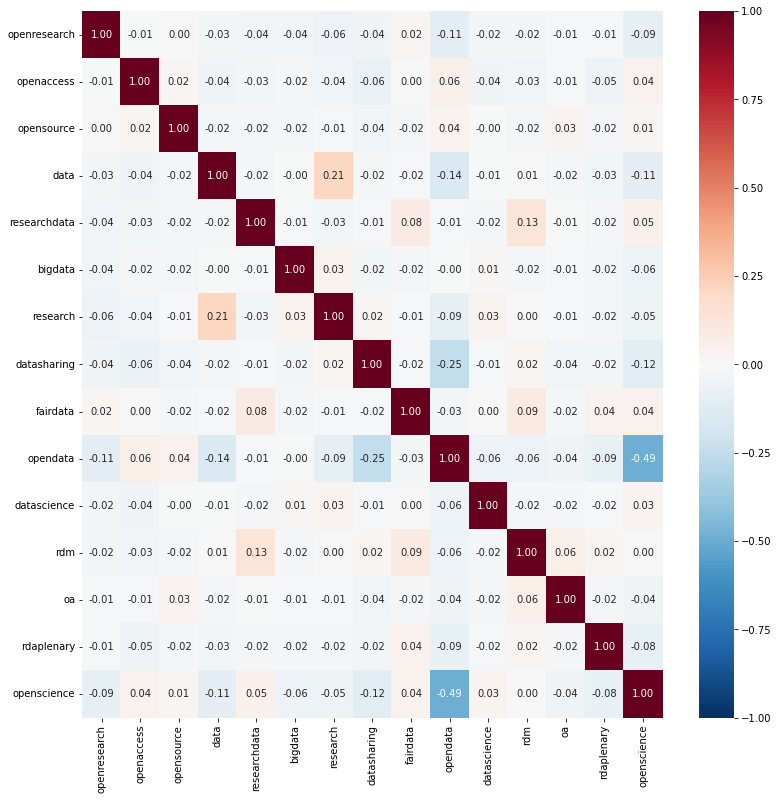

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
correlations = hashtag_matrix.corr()
fig = plt.figure(figsize=(13,13))
sns.heatmap(correlations,
    cmap='RdBu_r',
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=1)
plt.show()
fig.savefig('correlation.png')
files.download('correlation.png')

---

## 5. **SENTIMENT ANALYSIS**

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
keyword_df['polarity'] = keyword_df['text_clean_notop'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

  0%|          | 0/11959 [00:00<?, ?it/s]

In [ ]:
conditions = [
    (keyword_df['hashtags'].str.contains('opendata')),
    (keyword_df['hashtags'].str.contains('datasharing')),
    (keyword_df['hashtags'].str.contains('openscience')),
    (keyword_df['hashtags'].str.contains('openresearch')),
    (keyword_df['hashtags'].str.len() == 0)]
choices = ['#opendata', '#datasharing', '#openscience', '#openresearch', 'none']
keyword_df['4_hashtags'] = np.select(conditions, choices, default='others')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

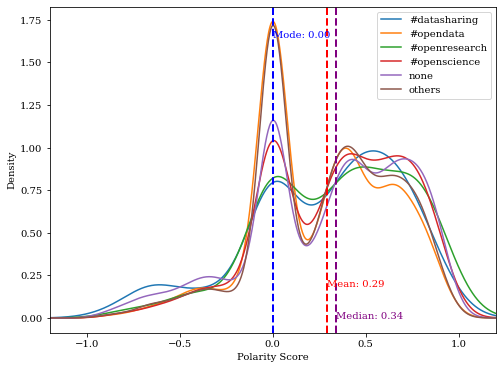

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'serif' # Font of text
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
keyword_df.groupby(by='4_hashtags').polarity.plot(legend=True, kind='kde', xlim = ([-1.2, 1.2]))
plt.xlabel("Polarity Score")
plt.axvline(statistics.mode(keyword_df.polarity), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(keyword_df.polarity.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(keyword_df.polarity), color='purple', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mode(keyword_df.polarity), max_ylim*0.9, 'Mode: {:.2f}'.format(statistics.mode(keyword_df.polarity)), color='blue')
plt.text(keyword_df.polarity.mean(), max_ylim*0.1, 'Mean: {:.2f}'.format(keyword_df.polarity.mean()), color='red')
plt.text(np.median(keyword_df.polarity), max_ylim*0.0, 'Median: {:.2f}'.format(np.median(keyword_df.polarity)), color='purple')
fig.savefig('polarity.png')
files.download('polarity.png')

### 5.1 Sentiment Analysis - Pre-Post Covid19 era

In [ ]:
filter_pre_covid['polarity'] = filter_pre_covid['text_clean_notop'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])
filter_post_covid['polarity'] = filter_post_covid['text_clean_notop'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

  0%|          | 0/3362 [00:00<?, ?it/s]

  0%|          | 0/2408 [00:00<?, ?it/s]

In [ ]:
conditions = [
    (filter_pre_covid['hashtags'].str.contains('opendata')),
    (filter_pre_covid['hashtags'].str.contains('datasharing')),
    (filter_pre_covid['hashtags'].str.contains('openscience')),
    (filter_pre_covid['hashtags'].str.contains('openresearch')),
    (filter_pre_covid['hashtags'].str.len() == 0)]
choices = ['#opendata', '#datasharing', '#openscience', '#openresearch', 'none']
filter_pre_covid['4_hashtags'] = np.select(conditions, choices, default='others')

conditions = [
    (filter_post_covid['hashtags'].str.contains('opendata')),
    (filter_post_covid['hashtags'].str.contains('datasharing')),
    (filter_post_covid['hashtags'].str.contains('openscience')),
    (filter_post_covid['hashtags'].str.contains('openresearch')),
    (filter_post_covid['hashtags'].str.len() == 0)]
choices = ['#opendata', '#datasharing', '#openscience', '#openresearch', 'none']
filter_post_covid['4_hashtags'] = np.select(conditions, choices, default='others')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

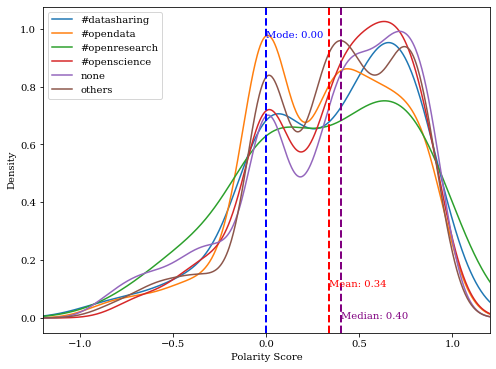

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'serif' # Font of text
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
filter_pre_covid.groupby(by='4_hashtags').polarity.plot(legend=True, kind='kde', xlim = ([-1.2, 1.2]))
plt.xlabel("Polarity Score")
plt.axvline(statistics.mode(filter_pre_covid.polarity), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(filter_pre_covid.polarity.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(filter_pre_covid.polarity), color='purple', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mode(filter_pre_covid.polarity), max_ylim*0.9, 'Mode: {:.2f}'.format(statistics.mode(filter_pre_covid.polarity)), color='blue')
plt.text(filter_pre_covid.polarity.mean(), max_ylim*0.1, 'Mean: {:.2f}'.format(filter_pre_covid.polarity.mean()), color='red')
plt.text(np.median(filter_pre_covid.polarity), max_ylim*0.0, 'Median: {:.2f}'.format(np.median(filter_pre_covid.polarity)), color='purple')
fig.savefig('polarity_pre.png')
files.download('polarity_pre.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

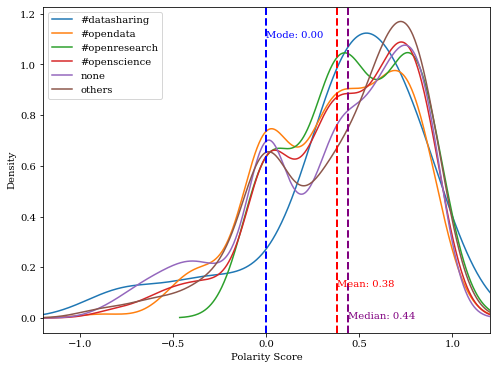

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'serif' # Font of text
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
filter_post_covid.groupby(by='4_hashtags').polarity.plot(legend=True, kind='kde', xlim = ([-1.2, 1.2]))
plt.xlabel("Polarity Score")
plt.axvline(statistics.mode(filter_post_covid.polarity), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(filter_post_covid.polarity.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(filter_post_covid.polarity), color='purple', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(statistics.mode(filter_post_covid.polarity), max_ylim*0.9, 'Mode: {:.2f}'.format(statistics.mode(filter_post_covid.polarity)), color='blue')
plt.text(filter_post_covid.polarity.mean(), max_ylim*0.1, 'Mean: {:.2f}'.format(filter_post_covid.polarity.mean()), color='red')
plt.text(np.median(filter_post_covid.polarity), max_ylim*0.0, 'Median: {:.2f}'.format(np.median(filter_post_covid.polarity)), color='purple')
fig.savefig('polarity_post.png')
files.download('polarity_post.png')

---

## 6. **TOPIC MODELING**

We employ LDA function by gensim.

In [ ]:
# Dictionary
id2word = corpora.Dictionary([d.split() for d in keyword_df['text_clean_notop']])
# Corpus
texts = [d.split() for d in keyword_df['text_clean_notop']]
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=200)
# Print the Keyword in the 10 topics
doc_lda = lda_model[corpus]

In [ ]:
df_lda = pd.DataFrame()
for topic_n, list_terms_w in lda_model.show_topics(formatted=False):
    df_tmp = pd.DataFrame(list_terms_w, columns=["Topic " + str(topic_n) + " word", "Topic " + str(topic_n) + " weight"])
    df_lda = pd.concat([df_lda, df_tmp], axis=1)

In [ ]:
df_lda

,Topic 0 word,Topic 0 weight,Topic 1 word,Topic 1 weight,Topic 2 word,Topic 2 weight,Topic 3 word,Topic 3 weight,Topic 4 word,Topic 4 weight
0,researcher,0.017279,share,0.014033,issue,0.009746,access,0.016304,researcher,0.013867
1,work,0.012403,people,0.011381,community,0.009430,researcher,0.016291,practice,0.010450
2,make,0.010761,like,0.010889,try,0.008939,need,0.011535,group,0.010141
3,find,0.009632,public,0.010130,paper,0.008698,share,0.010231,work,0.009575
4,share,0.009455,use,0.009807,think,0.007387,journal,0.010149,access,0.009326
5,health,0.009369,researcher,0.009731,researcher,0.007358,work,0.009617,state,0.008772
6,good,0.009244,study,0.008385,publish,0.007324,article,0.009109,talk,0.008426
7,question,0.009149,paper,0.007804,information,0.007284,review,0.008319,collaboration,0.008415
8,access,0.008550,support,0.007610,long,0.007236,find,0.008172,time,0.008078
9,management,0.008386,knowledge,0.007397,share,0.007179,dataset,0.007839,share,0.007979


In [ ]:
df_lda['Topic 0 weight'] = df_lda['Topic 0 weight'].astype(float)
df_lda['Topic 1 weight'] = df_lda['Topic 1 weight'].astype(float)
df_lda['Topic 2 weight'] = df_lda['Topic 2 weight'].astype(float)
df_lda['Topic 3 weight'] = df_lda['Topic 3 weight'].astype(float)
df_lda['Topic 4 weight'] = df_lda['Topic 4 weight'].astype(float)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_lda['Topic 0 weight'],
    x=df_lda['Topic 0 word'],
    marker_color='steelblue',
    name='Topic 0'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 1 weight'],
    x=df_lda['Topic 1 word'],
    marker_color='tan',
    name='Topic 1'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 2 weight'],
    x=df_lda['Topic 2 word'],
    marker_color='grey',
    name='Topic 2'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 3 weight'],
    x=df_lda['Topic 3 word'],
    marker_color='orchid',
    name='Topic 3'
    
))
fig.add_trace(go.Bar(
    y=df_lda['Topic 4 weight'],
    x=df_lda['Topic 4 word'],
    marker_color='lightseagreen',
    name='Topic 4'
    
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Topics - Filtered data',
                   yaxis_title='Weights', xaxis_title='Terms')
fig.show()

In [ ]:
perplexity = lda_model.log_perplexity(corpus)

In [ ]:
print('Perplexity:', perplexity)

Perplexity: -8.473253426816141


In [ ]:
coherence_model_lda = CoherenceModel(lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Perplexity:', coherence_lda)

Perplexity: 0.18624385097768442


In [ ]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
p

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.018643 -0.125769       1        1  25.038107
3     -0.104034 -0.111280       2        1  22.092286
0     -0.033506  0.262144       3        1  19.025113
4     -0.119749 -0.004514       4        1  18.189584
2      0.275932 -0.020581       5        1  15.654909, topic_info=           Term        Freq        Total Category  logprob  loglift
374       group  228.000000   228.000000  Default  30.0000  30.0000
310      people  548.000000   548.000000  Default  29.0000  29.0000
235        make  276.000000   276.000000  Default  28.0000  28.0000
273      health  220.000000   220.000000  Default  27.0000  27.0000
678    question  361.000000   361.000000  Default  26.0000  26.0000
..          ...         ...          ...      ...      ...      ...
89   researcher  142.204240  1604.621761   Topic5  -4.9120  -0.5690
8    scientific  101.895076   327.637766   Topic5  -5.2453   0.6864
283     support   99.273665   481.250178   Topic5  -5.2714   0.2759
66         look   95.899521   311.631878   Topic5  -5.3060   0.6759
6          need   95.558912   801.278120   Topic5  -5.3095  -0.2721

[332 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
598       5  0.979432  absolutely
294       1  0.296390    academic
294       2  0.219614    academic
294       3  0.203545    academic
294       4  0.144624    academic
...     ...       ...         ...
796       4  0.003466        year
796       5  0.020795        year
223       1  0.927470         yes
223       2  0.054557         yes
223       3  0.016367         yes

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [ ]:
pyLDAvis.save_html(p, 'pyLDAvis.html')

In [ ]:
files.download('pyLDAvis.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6.1 Topic modeling - Pre-Post Covid19 era

Pre Covid data topic modeling

In [ ]:
# Dictionary
id2word_pre = corpora.Dictionary([d.split() for d in filter_pre_covid['text_clean_notop']])
# Corpus
texts_pre = [d.split() for d in filter_pre_covid['text_clean_notop']]
# Term Document Frequency
corpus_pre = [id2word_pre.doc2bow(text) for text in texts_pre]

In [ ]:
num_topics = 5
# Build LDA model
lda_model_pre = gensim.models.LdaMulticore(corpus=corpus_pre, id2word=id2word_pre, num_topics=num_topics, chunksize=200)
# Print the Keyword in the 10 topics
doc_lda_pre = lda_model_pre[corpus_pre]

In [ ]:
df_lda_pre = pd.DataFrame()
for topic_n, list_terms_w in lda_model_pre.show_topics(formatted=False):
    df_tmp_pre = pd.DataFrame(list_terms_w, columns=["Topic " + str(topic_n) + " word", "Topic " + str(topic_n) + " weight"])
    df_lda_pre = pd.concat([df_lda_pre, df_tmp_pre], axis=1)

In [ ]:
df_lda_pre

,Topic 0 word,Topic 0 weight,Topic 1 word,Topic 1 weight,Topic 2 word,Topic 2 weight,Topic 3 word,Topic 3 weight,Topic 4 word,Topic 4 weight
0,share,0.011134,researcher,0.014379,share,0.011846,researcher,0.011435,work,0.016574
1,access,0.009808,good,0.011171,like,0.011685,support,0.010662,researcher,0.007500
2,need,0.008602,access,0.010235,way,0.008706,management,0.009616,access,0.006656
3,paper,0.006996,practice,0.007558,researcher,0.008556,need,0.008777,like,0.006497
4,publish,0.006993,share,0.006095,find,0.007907,talk,0.008250,area,0.005828
5,analysis,0.006404,need,0.005794,new,0.007565,come,0.007033,write,0.005818
6,researcher,0.006169,use,0.005535,access,0.007372,fair,0.006515,know,0.005806
7,mean,0.005896,academic,0.004682,thing,0.006747,work,0.006435,think,0.005655
8,grant,0.005875,people,0.004206,good,0.006615,commercial,0.005850,risk,0.005206
9,think,0.005655,interested,0.004187,use,0.006486,find,0.005546,important,0.005168


In [ ]:
df_lda_pre['Topic 0 weight'] = df_lda_pre['Topic 0 weight'].astype(float)
df_lda_pre['Topic 1 weight'] = df_lda_pre['Topic 1 weight'].astype(float)
df_lda_pre['Topic 2 weight'] = df_lda_pre['Topic 2 weight'].astype(float)
df_lda_pre['Topic 3 weight'] = df_lda_pre['Topic 3 weight'].astype(float)
df_lda_pre['Topic 4 weight'] = df_lda_pre['Topic 4 weight'].astype(float)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 0 weight'],
    x=df_lda_pre['Topic 0 word'],
    marker_color='steelblue',
    name='Topic 0'

))
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 1 weight'],
    x=df_lda_pre['Topic 1 word'],
    marker_color='tan',
    name='Topic 1'

))
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 2 weight'],
    x=df_lda_pre['Topic 2 word'],
    marker_color='grey',
    name='Topic 2'

))
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 3 weight'],
    x=df_lda_pre['Topic 3 word'],
    marker_color='orchid',
    name='Topic 3'
    
))
fig.add_trace(go.Bar(    y=df_lda_pre['Topic 4 weight'],    x=df_lda_pre['Topic 4 word'],    marker_color='lightseagreen',    name='Topic 4'))



fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Topics Pre-Covid19 era',
                   yaxis_title='Weights', xaxis_title='Terms')
fig.show()

In [ ]:
perplexity_pre = lda_model_pre.log_perplexity(corpus_pre)

In [ ]:
print('Perplexity:', perplexity_pre)

Perplexity: -8.480802663686966


In [ ]:
coherence_model_lda_pre = CoherenceModel(lda_model_pre, texts=texts_pre, dictionary=id2word_pre, coherence='c_v')
coherence_lda_pre = coherence_model_lda_pre.get_coherence()
print('Perplexity:', coherence_lda_pre)

Perplexity: 0.20961834429138318


In [ ]:
p_pre = pyLDAvis.gensim_models.prepare(lda_model_pre, corpus_pre, id2word_pre)
p_pre

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.083588 -0.068270       1        1  25.648537
2     -0.042243 -0.063339       2        1  24.951311
1     -0.003102 -0.046997       3        1  18.830642
3      0.186830  0.007408       4        1  15.292508
4     -0.057897  0.171199       5        1  15.277001, topic_info=            Term        Freq       Total Category  logprob  loglift
209   management   87.000000   87.000000  Default  30.0000  30.0000
123         work  299.000000  299.000000  Default  29.0000  29.0000
502      support  157.000000  157.000000  Default  28.0000  28.0000
124         fair   51.000000   51.000000  Default  27.0000  27.0000
1031  commercial   41.000000   41.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
14        people   33.325697  172.574461   Topic5  -5.3371   0.2343
363         well   26.468553  101.333865   Topic5  -5.5675   0.5364
481        thing   26.177094  136.989525   Topic5  -5.5786   0.2238
173         need   26.814380  267.891569   Topic5  -5.5545  -0.4228
62           way   25.173253  171.079289   Topic5  -5.6177  -0.0375

[389 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3543      5  0.906371   ability
0         3  0.948665      able
0         4  0.033881      able
0         5  0.033881      able
204       1  0.382273  academic
...     ...       ...       ...
1582      1  0.936642     wrong
239       1  0.601690      year
239       2  0.203963      year
239       3  0.122378      year
239       4  0.071387      year

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [ ]:
pyLDAvis.save_html(p_pre, 'pyLDAvis_pre.html')

In [ ]:
files.download('pyLDAvis_pre.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Post Covid data topic modeling

In [ ]:
# Dictionary
id2word_post = corpora.Dictionary([d.split() for d in filter_post_covid['text_clean_notop']])
# Corpus
texts_post = [d.split() for d in filter_post_covid['text_clean_notop']]
# Term Document Frequency
corpus_post = [id2word_post.doc2bow(text) for text in texts_post]

In [ ]:
num_topics = 5
# Build LDA model
lda_model_post = gensim.models.LdaMulticore(corpus=corpus_post, id2word=id2word_post, num_topics=num_topics, chunksize=200)
# Print the Keyword in the 10 topics
doc_lda_post = lda_model_post[corpus_post]

In [ ]:
df_lda_post = pd.DataFrame()
for topic_n, list_terms_w in lda_model_post.show_topics(formatted=False):
    df_tmp_post = pd.DataFrame(list_terms_w, columns=["Topic " + str(topic_n) + " word", "Topic " + str(topic_n) + " weight"])
    df_lda_post = pd.concat([df_lda_post, df_tmp_post], axis=1)

In [ ]:
df_lda_post

,Topic 0 word,Topic 0 weight,Topic 1 word,Topic 1 weight,Topic 2 word,Topic 2 weight,Topic 3 word,Topic 3 weight,Topic 4 word,Topic 4 weight
0,protection,0.027705,article,0.013318,community,0.021140,healthcare,0.014676,access,0.032182
1,community,0.014783,available,0.012917,publish,0.015166,charge,0.012832,researcher,0.016290
2,death,0.012955,month,0.011470,active,0.014739,university,0.009166,publication,0.012055
3,international,0.012641,dataset,0.011230,potentially,0.014416,report,0.009049,share,0.011163
4,researcher,0.012484,secure,0.010926,rate,0.014259,share,0.008568,enhance,0.010721
5,innovator,0.012469,freely,0.010717,simulation,0.014124,paper,0.008007,study,0.010498
6,world,0.012263,entire,0.010706,relevant,0.013907,need,0.007866,database,0.010132
7,find,0.008831,script,0.010646,article,0.012950,researcher,0.007170,paper,0.009838
8,access,0.007374,intervention,0.010630,tell,0.012670,academic,0.007148,want,0.009680
9,like,0.007334,section,0.010593,incidence,0.009253,knowledge,0.006784,monitor,0.008430


In [ ]:
df_lda_post['Topic 0 weight'] = df_lda_post['Topic 0 weight'].astype(float)
df_lda_post['Topic 1 weight'] = df_lda_post['Topic 1 weight'].astype(float)
df_lda_post['Topic 2 weight'] = df_lda_post['Topic 2 weight'].astype(float)
df_lda_post['Topic 3 weight'] = df_lda_post['Topic 3 weight'].astype(float)
df_lda_post['Topic 4 weight'] = df_lda_post['Topic 4 weight'].astype(float)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_lda_post['Topic 0 weight'],
    x=df_lda_post['Topic 0 word'],
    marker_color='steelblue',
    name='Topic 0'

))
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 1 weight'],
    x=df_lda_post['Topic 1 word'],
    marker_color='tan',
    name='Topic 1'

))
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 2 weight'],
    x=df_lda_post['Topic 2 word'],
    marker_color='grey',
    name='Topic 2'

))
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 3 weight'],
    x=df_lda_post['Topic 3 word'],
    marker_color='orchid',
    name='Topic 3'
    
))
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 4 weight'],
    x=df_lda_post['Topic 4 word'],
    marker_color='lightseagreen',
    name='Topic 4'
    
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Topics Post-Covid19 era',
                   yaxis_title='Weights', xaxis_title='Terms')
fig.show()

In [ ]:
perplexity_post = lda_model_post.log_perplexity(corpus_post)

In [ ]:
print('Perplexity:', perplexity_post)

Perplexity: -8.526505205369137


In [ ]:
coherence_model_lda_post = CoherenceModel(lda_model_post, texts=texts_post, dictionary=id2word_post, coherence='c_v')
coherence_lda_post = coherence_model_lda_post.get_coherence()
print('Perplexity:', coherence_lda_post)

Perplexity: 0.4126339670921221


In [ ]:
p_post = pyLDAvis.gensim_models.prepare(lda_model_post, corpus_post, id2word_post)
p_post

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.072172 -0.026733       1        1  26.628877
3     -0.005901 -0.072328       2        1  22.173715
1      0.136034  0.058174       3        1  18.599593
0     -0.090759 -0.089016       4        1  16.649674
2     -0.111546  0.129903       5        1  15.948140, topic_info=             Term        Freq       Total Category  logprob  loglift
1912   protection  158.000000  158.000000  Default  30.0000  30.0000
1481   healthcare  114.000000  114.000000  Default  29.0000  29.0000
1254       active   81.000000   81.000000  Default  28.0000  28.0000
460   potentially   79.000000   79.000000  Default  27.0000  27.0000
614    simulation   77.000000   77.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
63           like   21.118946  132.432094   Topic5  -5.5469  -0.0001
830         field   20.652789  112.368812   Topic5  -5.5692   0.1419
48         people   20.467558  108.783865   Topic5  -5.5782   0.1653
92     researcher   21.573682  332.822913   Topic5  -5.5256  -0.9003
196     knowledge   20.530739  119.426061   Topic5  -5.5752   0.0751

[352 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
667       1  0.150760  academic
667       2  0.452280  academic
667       3  0.108882  academic
667       4  0.033502  academic
667       5  0.251267  academic
...     ...       ...       ...
79        3  0.112219     world
79        4  0.645258     world
79        5  0.009352     world
699       1  0.953395     wrong
1171      4  0.896594      yeah

[704 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [ ]:
pyLDAvis.save_html(p_post, 'pyLDAvis_post.html')

In [ ]:
files.download('pyLDAvis_post.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig = go.Figure()

#fig = make_subplots(rows=3, cols=1, subplot_titles=("Total", "Pre-Covid19 era", "Post-Covi19 era"))
fig = make_subplots(rows=2, cols=1, subplot_titles=("Pre-Covid19 era", "Post-Covid19 era"))

fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 0 weight'],
    x=df_lda_pre['Topic 0 word'],
    marker_color='steelblue',
    name='Topic 0'

), row=1, col=1)
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 1 weight'],
    x=df_lda_pre['Topic 1 word'],
    marker_color='tan',
    name='Topic 1'

), row=1, col=1)
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 2 weight'],
    x=df_lda_pre['Topic 2 word'],
    marker_color='grey',
    name='Topic 2'

), row=1, col=1)
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 3 weight'],
    x=df_lda_pre['Topic 3 word'],
    marker_color='orchid',
    name='Topic 3'
    
), row=1, col=1)
fig.add_trace(go.Bar(
    y=df_lda_pre['Topic 4 weight'],
    x=df_lda_pre['Topic 4 word'],
    marker_color='lightseagreen',
    name='Topic 4'
    
), row=1, col=1)


fig.add_trace(go.Bar(
    y=df_lda_post['Topic 0 weight'],
    x=df_lda_post['Topic 0 word'],
    marker_color='steelblue',
    name='Topic 0'

, legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 1 weight'],
    x=df_lda_post['Topic 1 word'],
    marker_color='tan',
    name='Topic 1'

, legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 2 weight'],
    x=df_lda_post['Topic 2 word'],
    marker_color='grey',
    name='Topic 2'

, legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 3 weight'],
    x=df_lda_post['Topic 3 word'],
    marker_color='orchid',
    name='Topic 3'
    
, legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(
    y=df_lda_post['Topic 4 weight'],
    x=df_lda_post['Topic 4 word'],
    marker_color='lightseagreen',
    name='Topic 4'
    
, legendgroup='group1', showlegend=False), row=2, col=1)



fig.update_xaxes(tickmode='linear', title_text= "Terms", tickangle=-45, row=1, col=1)
fig.update_xaxes(tickmode='linear', title_text= "Terms", tickangle=-45, row=2, col=1)
#fig.update_xaxes(tickmode='linear', tickangle=-45, row=3, col=1)

fig.update_yaxes(title_text="Weights", row=1, col=1)
fig.update_yaxes(title_text="Weights", row=2, col=1)
#fig.update_yaxes(title_text="Words Frequency %", row=3, col=1)


fig.update_layout(barmode='group',  title='Topics - Pre-Post Covid19 era',  height=1000)

fig.show()

In [ ]:
with open("/content/drive/MyDrive/Università/Thesis/lda_model.pkl", "wb") as f:
    pickle.dump(lda_model, f)
with open("/content/drive/MyDrive/Università/Thesis/lda_model_post.pkl", "wb") as f:
    pickle.dump(lda_model_post, f)
with open("/content/drive/MyDrive/Università/Thesis/lda_model_pre.pkl", "wb") as f:
    pickle.dump(lda_model_pre, f)
with open("/content/drive/MyDrive/Università/Thesis/df_lda.pkl", "wb") as f:
    pickle.dump(df_lda, f)
with open("/content/drive/MyDrive/Università/Thesis/df_lda_pre.pkl", "wb") as f:
    pickle.dump(df_lda_pre, f)
with open("/content/drive/MyDrive/Università/Thesis/df_lda_post.pkl", "wb") as f:
    pickle.dump(df_lda_post, f)

---

## **7. PERSPECTIVES THROUGH MODAL VERBS**

In [ ]:
list_perspectives = ['could', 'has to', 'have to',  'may', 'might', 'need to' , 'ought to', 'shall', 'should'] # 1842

*  Could 313
*  Has to 43 
*  Have to 136
*  May 328
*  Might 155
*  Must 143
*  Need to 337
*  Ought to 7
*  Shall 15
*  Should 671
---
ADVICE (should, shall, ought to) : 691  (5.78%)

OBLIGATION (must, have to, need to, has to): 650  (5.44%)

POSSIBILITY (might, may, could, can) - also ABILITY: 771  (6.45%)




In [ ]:
advice = ['should', 'shall', 'ought to'] # 691
obligation = ['must', 'have to', 'has to', 'need to'] # 650
possibility = ['might', 'may', 'could'] # 771

In [ ]:
keyword_df[keyword_df['text'].str.contains('|'.join(possibility), case=False)].shape[0]

771

In [ ]:
advice_df = keyword_df[keyword_df['text'].str.contains('|'.join(advice), case=False)]
obligation_df = keyword_df[keyword_df['text'].str.contains('|'.join(obligation), case=False)]
possibility_df = keyword_df[keyword_df['text'].str.contains('|'.join(possibility), case=False)]

In [ ]:
cmw_advice = get_top_n_words_(advice_df['text_clean_notop'], 50)
cmw_advice.columns = ["words", "freq"]
cmw_obligation = get_top_n_words_(obligation_df['text_clean_notop'], 50)
cmw_obligation.columns = ["words", "freq"]
cmw_possibility = get_top_n_words_(possibility_df['text_clean_notop'], 50)
cmw_possibility.columns = ["words", "freq"]

In [ ]:
intersection_modal = reduce(np.intersect1d, [cmw_advice['words'], cmw_obligation['words'], cmw_possibility['words']])

In [ ]:
df_modal = pd.concat([cmw_advice, cmw_obligation, cmw_possibility], axis=1)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_advice['words'][cmw_advice['words'].isin(intersection_modal)],
    y=cmw_advice['freq'][~cmw_advice['words'].isin(intersection_modal)],
    name='advice',
    marker_color='steelblue',
))
fig.add_trace(go.Bar(
    x=cmw_obligation['words'][cmw_obligation['words'].isin(intersection_modal)],
    y=cmw_obligation['freq'][cmw_obligation['words'].isin(intersection_modal)],
    name='obligation',
    marker_color='tan'
))
fig.add_trace(go.Bar(
    x=cmw_possibility['words'][cmw_possibility['words'].isin(intersection_modal)],
    y=cmw_possibility['freq'][cmw_possibility['words'].isin(intersection_modal)],
    name='possibility/advice',
    marker_color='grey'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Common Terms within top 50 modal verbs - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_advice['words'][~cmw_advice['words'].isin(intersection_modal)],
    y=cmw_advice['freq'][~cmw_advice['words'].isin(intersection_modal)],
    name='advice',
    marker_color='steelblue',
))
fig.add_trace(go.Bar(
    x=cmw_obligation['words'][~cmw_obligation['words'].isin(intersection_modal)],
    y=cmw_obligation['freq'][~cmw_obligation['words'].isin(intersection_modal)],
    name='obligation',
    marker_color='tan'
))
fig.add_trace(go.Bar(
    x=cmw_possibility['words'][~cmw_possibility['words'].isin(intersection_modal)],
    y=cmw_possibility['freq'][~cmw_possibility['words'].isin(intersection_modal)],
    name='possibility/advice',
    marker_color='grey'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Uncommon Terms within top 50 modal verbs - Filtered data',
                   yaxis_title='Words Frequency %')
fig.show()

### 7.1 Perspectives Through Modal Verbs - Pre-Post Covid19 era

ADVICE:

*   Pre-Covid19 era: 246  (7.32%)
*   Post-Covid19 era: 163  (6.77%)

OBLIGATION:

*   Pre-Covid19 era: 232  (6.9%)
*   Post-Covid19 era: 143  (5.94%)

POSSIBILITY:

*   Pre-Covid19 era: 312  (9.28%)
*   Post-Covid19 era: 235  (9.76%)





In [ ]:
advice_df_pre = filter_pre_covid[filter_pre_covid['text'].str.contains('|'.join(advice), case=False)]
obligation_df_pre = filter_pre_covid[filter_pre_covid['text'].str.contains('|'.join(obligation), case=False)]
possibility_df_pre = filter_pre_covid[filter_pre_covid['text'].str.contains('|'.join(possibility), case=False)]

In [ ]:
advice_df_post = filter_post_covid[filter_post_covid['text'].str.contains('|'.join(advice), case=False)]
obligation_df_post = filter_post_covid[filter_post_covid['text'].str.contains('|'.join(obligation), case=False)]
possibility_df_post = filter_post_covid[filter_post_covid['text'].str.contains('|'.join(possibility), case=False)]

In [ ]:
cmw_advice_pre = get_top_n_words_(advice_df_pre['text_clean_notop'], 50)
cmw_advice_pre.columns = ["words", "freq"]
cmw_obligation_pre = get_top_n_words_(obligation_df_pre['text_clean_notop'], 50)
cmw_obligation_pre.columns = ["words", "freq"]
cmw_possibility_pre = get_top_n_words_(possibility_df_pre['text_clean_notop'], 50)
cmw_possibility_pre.columns = ["words", "freq"]

In [ ]:
cmw_advice_post = get_top_n_words_(advice_df_post['text_clean_notop'], 50)
cmw_advice_post.columns = ["words", "freq"]
cmw_obligation_post = get_top_n_words_(obligation_df_post['text_clean_notop'], 50)
cmw_obligation_post.columns = ["words", "freq"]
cmw_possibility_post = get_top_n_words_(possibility_df_post['text_clean_notop'], 50)
cmw_possibility_post.columns = ["words", "freq"]

In [ ]:
intersection_advice = reduce(np.intersect1d, [cmw_advice_pre['words'], cmw_advice_post['words']])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cmw_advice_pre['words'][~cmw_advice_pre['words'].isin(intersection_advice)],
    y=cmw_advice_pre['freq'][~cmw_advice_pre['words'].isin(intersection_advice)],
    name='advice',
    marker_color='steelblue',
))
fig.add_trace(go.Bar(
    x=cmw_advice_post['words'][~cmw_advice_post['words'].isin(intersection_advice)],
    y=cmw_advice_post['freq'][~cmw_advice_post['words'].isin(intersection_advice)],
    name='obligation',
    marker_color='tan'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Frequent Uncommon Terms within top 50 modal verbs - Pre-Post Covid19 era',
                   yaxis_title='Words Frequency %')
fig.show()

In [ ]:
year_advice = pd.DataFrame(advice_df['date'].dt.year.value_counts()).sort_index().reset_index()
year_advice.columns = ['year', 'count']
year_advice['rel_frequency'] = ((year_advice['count'] /  year_advice['count'].sum()) * 100).round(2)
year_obligation = pd.DataFrame(obligation_df['date'].dt.year.value_counts()).sort_index().reset_index()
year_obligation.columns = ['year', 'count']
year_obligation['rel_frequency'] = ((year_obligation['count'] /  year_obligation['count'].sum()) * 100).round(2)
year_possibility = pd.DataFrame(possibility_df['date'].dt.year.value_counts()).sort_index().reset_index()
year_possibility.columns = ['year', 'count']
year_possibility['rel_frequency'] = ((year_possibility['count'] /  year_possibility['count'].sum()) * 100).round(2)

In [ ]:
year_possibility

,year,count,rel_frequency
0,2009,2,0.26
1,2010,4,0.52
2,2011,7,0.91
3,2012,11,1.43
4,2013,31,4.02
5,2014,29,3.76
6,2015,42,5.45
7,2016,41,5.32
8,2017,57,7.39
9,2018,148,19.20


In [ ]:
fig = go.Figure()

fig = make_subplots(rows=2, cols=1, subplot_titles=("Absolute Frequency", "Relative Frequency"), vertical_spacing=0.15) #, row_heights=[2,2]

fig.add_trace(go.Scatter(x=year_advice['year'], y=year_advice['count'],
                   name='Advice Modality', line = dict(color='royalblue')), row=1, col=1)
fig.add_trace(go.Scatter(x=year_obligation['year'], y=year_obligation['count'],
                   name='Obligation Modality', line = dict(color='firebrick')), row=1, col=1)
fig.add_trace(go.Scatter(x=year_possibility['year'], y=year_possibility['count'],
                   name='Possibility Modality', line = dict(color='gold')), row=1, col=1)

fig.add_trace(go.Scatter(x=year_advice['year'], y=year_advice['rel_frequency'],
                   name='Advice Modality', line = dict(color='royalblue'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=year_obligation['year'], y=year_obligation['rel_frequency'],
                   name='Obligation Modality', line = dict(color='firebrick'), legendgroup='group1', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=year_possibility['year'], y=year_possibility['rel_frequency'],
                   name='Possibility Modality', line = dict(color='gold'), legendgroup='group1', showlegend=False), row=2, col=1)

fig.update_xaxes(title_text="Years", row=1, col=1)
fig.update_xaxes(title_text="Years", row=2, col=1)

fig.update_yaxes(title_text="N", row=1, col=1)
fig.update_yaxes(title_text="%", row=2, col=1)


fig.update_layout(title_text="Frequency of tweets with modal verbs within years by modality - Filtered data", height=800, width=1400)

fig.show()